# Загрузка и анализ датасета

Ссылка на репозиторий: https://github.com/sismetanin/rureviews <br>
Ссылка на датасет: https://github.com/sismetanin/rureviews/raw/refs/heads/master/women-clothing-accessories.3-class.balanced.csv

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import tokenizers
import torch
from pytorch_lightning import LightningDataModule
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy, ConfusionMatrix, F1Score, Precision, Recall

In [3]:
df = pd.read_csv(
    "https://github.com/sismetanin/rureviews/raw/refs/heads/master/women-clothing-accessories.3-class.balanced.csv",
    sep="\t",
)

In [4]:
df.head()

,review,sentiment
0,качество плохое пошив ужасный (горловина напер...,negative
1,"Товар отдали другому человеку, я не получила п...",negative
2,"Ужасная синтетика! Тонкая, ничего общего с пре...",negative
3,"товар не пришел, продавец продлил защиту без м...",negative
4,"Кофточка голая синтетика, носить не возможно.",negative


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90000 entries, 0 to 89999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     90000 non-null  object
 1   sentiment  90000 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


пропущенных значений нет

In [6]:
df["sentiment"].unique()

array(['negative', 'neautral', 'positive'], dtype=object)

всего 3 метки классов

<Axes: xlabel='sentiment', ylabel='Count'>

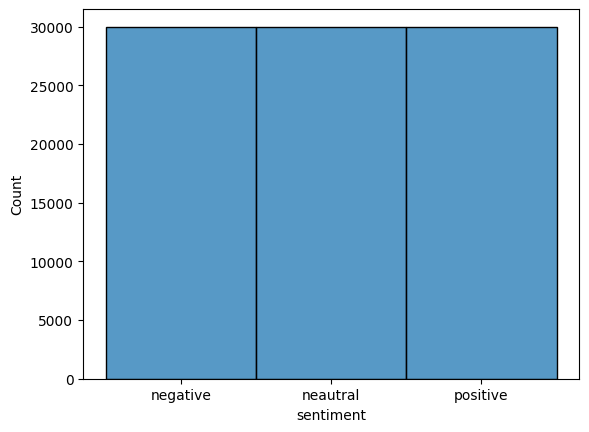

In [7]:
sns.histplot(df, x="sentiment")

датасет подготовлен хорошо, дисбаланса классов нет

In [8]:
label_mapping = {"negative": 0, "neautral": 1, "positive": 2}
inverse_label_mapping = {v: k for k, v in label_mapping.items()}

df_mapped = df.copy()

df_mapped["sentiment"] = df["sentiment"].map(label_mapping)
df_mapped["sentiment"].unique()

array([0, 1, 2])

# Подготовка токенайзера

In [27]:
tokenizer = tokenizers.SentencePieceBPETokenizer()
tokenizer.normalizer = tokenizers.normalizers.Sequence(
    [
        tokenizers.normalizers.NFD(),
        tokenizers.normalizers.Lowercase(),
        tokenizers.normalizers.StripAccents(),
    ]
)

tokenizer.train_from_iterator(df_mapped["review"].to_list(), special_tokens=["<unk>", "<pad>"])
tokenizer.save("rnn_tokenizer.json")

In [32]:
tokenizer = tokenizers.Tokenizer.from_file("rnn_tokenizer.json")

# Определение класса датасета

In [10]:
class TextDataset(Dataset):
    """Датасет для текстовых данных."""

    def __init__(self, dataframe, text_column, target_column, tokenizer, max_length=128):
        self.dataframe = dataframe.reset_index(drop=True)
        self.text_column = text_column
        self.target_column = target_column
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = str(self.dataframe.loc[idx, self.text_column])
        label = int(self.dataframe.loc[idx, self.target_column])
        encoding = self.tokenizer.encode(text)
        input_ids = encoding.ids[: self.max_length]

        if len(input_ids) < self.max_length:
            input_ids += [self.tokenizer.token_to_id("<pad>")] * (self.max_length - len(input_ids))

        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

Проверка что все корректно работает

In [11]:
dataset = TextDataset(df_mapped, "review", "sentiment", tokenizer)

In [30]:
text, label = dataset[0]
tokenizer.decode(text.numpy()), inverse_label_mapping[int(label.item())]

('качество плохое пошив ужасныи (горловина наперекос) фото не соответствует ткань ужасная рисунок блеклыи маленькии рукав не такои ужас!!!!! не стоит за такие деньги г.......',
 'negative')

# Определение класса модуля для загрузки данных

In [13]:
class TextDataModule(LightningDataModule):
    """Датамодуль для обучения модели с разделением данных."""

    def __init__(self, df, text_col, target_col, tokenizer, batch_size=32, max_length=128, num_workers=2):
        super().__init__()
        self.df = df
        self.text_col = text_col
        self.target_col = target_col
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_length = max_length
        self.num_workers = num_workers

    def setup(self, stage=None):
        train_df, temp_df = train_test_split(self.df, test_size=0.3, random_state=42, stratify=self.df[self.target_col])
        val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df[self.target_col])

        self.train_dataset = TextDataset(train_df, self.text_col, self.target_col, self.tokenizer, self.max_length)
        self.val_dataset = TextDataset(val_df, self.text_col, self.target_col, self.tokenizer, self.max_length)
        self.test_dataset = TextDataset(test_df, self.text_col, self.target_col, self.tokenizer, self.max_length)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.num_workers,
            persistent_workers=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            persistent_workers=True,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
            persistent_workers=True,
        )

проверка что все работает корректно

In [14]:
dm = TextDataModule(
    df=df_mapped,
    text_col="review",
    target_col="sentiment",
    tokenizer=tokenizer,
    batch_size=256,
)
dm.setup()

In [15]:
batch = next(iter(dm.train_dataloader()))
print("✅ input_ids shape:", batch[0].shape)
print("✅ labels sample:", batch[1])

/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ input_ids shape: torch.Size([256, 128])
✅ labels sample: tensor([2, 1, 0, 0, 2, 0, 2, 2, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 1,
        1, 1, 1, 2, 0, 1, 0, 1, 2, 1, 2, 2, 1, 0, 2, 0, 0, 0, 1, 1, 1, 2, 1, 2,
        1, 0, 0, 2, 2, 2, 2, 2, 0, 1, 2, 1, 2, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 2,
        0, 0, 1, 1, 1, 2, 0, 0, 2, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 2, 1, 1, 0, 1,
        2, 1, 2, 0, 2, 2, 2, 1, 0, 2, 0, 1, 2, 0, 0, 0, 0, 2, 0, 1, 1, 2, 2, 1,
        1, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 0, 0, 0, 0, 2, 1,
        1, 1, 2, 0, 1, 2, 0, 0, 0, 1, 0, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2,
        1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 2,
        0, 2, 1, 0, 2, 2, 2, 2, 2, 2, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 0, 1,
        1, 0, 0, 2, 2, 1, 0, 1, 2, 2, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 0, 0, 1, 2,
        2, 1, 1, 0, 1, 1, 2, 0, 2, 0, 0, 2, 1, 0, 2, 2])


In [16]:
batch = next(iter(dm.val_dataloader()))
print("✅ input_ids shape:", batch[0].shape)
print("✅ labels sample:", batch[1])

✅ input_ids shape: torch.Size([256, 128])
✅ labels sample: tensor([2, 1, 2, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 2, 1, 0, 0, 1, 0, 2, 1, 2, 0, 0,
        1, 0, 1, 2, 0, 1, 2, 1, 2, 0, 0, 2, 2, 1, 0, 2, 0, 1, 0, 1, 1, 2, 1, 2,
        1, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 2, 2, 1, 2, 2, 0, 0, 0, 2, 2, 0, 0, 0,
        1, 1, 0, 0, 1, 0, 2, 0, 1, 2, 0, 1, 1, 2, 1, 0, 1, 0, 0, 0, 0, 2, 0, 0,
        1, 1, 1, 1, 2, 0, 2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 2, 0, 2, 2,
        0, 0, 1, 2, 0, 2, 2, 1, 1, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 2, 2, 0, 0,
        2, 2, 2, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 1, 2, 1, 2, 2, 0, 0, 2, 0, 0, 1,
        0, 1, 1, 2, 1, 2, 0, 0, 2, 1, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 0, 0, 2, 0,
        2, 2, 2, 2, 0, 1, 2, 1, 2, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 2, 2, 2, 0,
        1, 0, 1, 2, 2, 0, 2, 0, 1, 1, 1, 1, 1, 2, 0, 1, 2, 2, 2, 0, 1, 0, 0, 2,
        1, 0, 1, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 0])


In [17]:
batch = next(iter(dm.test_dataloader()))
print("✅ input_ids shape:", batch[0].shape)
print("✅ labels sample:", batch[1])

✅ input_ids shape: torch.Size([256, 128])
✅ labels sample: tensor([2, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 0, 2, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        1, 1, 0, 1, 1, 0, 0, 2, 1, 2, 1, 1, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2, 1,
        2, 2, 0, 2, 0, 2, 2, 0, 0, 1, 0, 0, 0, 0, 2, 2, 0, 2, 1, 1, 0, 2, 2, 2,
        1, 0, 2, 2, 0, 2, 1, 2, 0, 1, 0, 1, 2, 2, 1, 0, 1, 2, 0, 1, 2, 0, 1, 2,
        2, 2, 2, 1, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2,
        2, 1, 2, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 2, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1,
        1, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1,
        1, 1, 1, 2, 0, 2, 0, 1, 2, 0, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 0,
        0, 1, 0, 1, 2, 2, 1, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 1, 0, 2, 1, 1, 0,
        1, 0, 1, 2, 0, 2, 0, 1, 2, 0, 2, 2, 1, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 2, 0, 0, 2, 2])


# Определение класса модели

In [18]:
class RnnClassifier(nn.Module):
    """Модель для классификации текста на эмоциональную окраску."""

    def __init__(
        self,
        vocab_size: int,
        embed_size: int,
        hidden_size: int,
        n_layers: int,
        output_size: int,
        rnn_class: nn.RNNBase,
        padding_idx: int,
        dropout: float = 0.3,
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=padding_idx)
        self.rnn = rnn_class(
            embed_size,
            hidden_size,
            n_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if n_layers > 1 else 0,
        )
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        out = self.rnn(embedded)

        if isinstance(self.rnn, nn.LSTM):
            output, (hidden, cell) = out
        else:
            output, hidden = out

        # Берём скрытые состояния последнего слоя: forward и backward
        # hidden: (num_layers * num_directions, batch_size, hidden_size)
        # Для последнего слоя:
        h_forward = hidden[-2]  # forward направление последнего слоя
        h_backward = hidden[-1]  # backward направление последнего слоя
        h_concat = torch.cat([h_forward, h_backward], dim=1)  # (B, H*2)
        h_concat = self.dropout(h_concat)

        return self.classifier(h_concat)


In [19]:
class LightningModelWrapper(pl.LightningModule):
    """Обертка над моделью для упрощения обучения."""

    def __init__(self, model: nn.Module, pad_index: int):
        super().__init__()
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=pad_index)
        self.model = model

    def forward(self, x: torch.Tensor):
        return self.model(x)

    def _step(self, batch: torch.Tensor, batch_idx: int, name: str):
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log(f"{name}_loss", loss)
        self.log(f"{name}_acc", acc, prog_bar=True)
        return loss

    def training_step(self, batch: torch.Tensor, batch_idx: int):
        return self._step(batch, batch_idx, "train")

    def validation_step(self, batch: torch.Tensor, batch_idx: int):
        self._step(batch, batch_idx, "val")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

# Обучение модели на основе RNN, LSTM, GRU

In [ ]:
def start_leaning(
    name: str,
    n_layers: int,
    embed_size: int,
    hidden_size: int,
    rnn_class: nn.RNNBase,
    datamodule: TextDataModule,
    tokenizer: tokenizers.Tokenizer,
):
    """Запустить обучение модели."""
    torch.manual_seed(42)
    logger = TensorBoardLogger(
        save_dir="logs",
        name=name,
    )
    checkpoint_callback = ModelCheckpoint(
        dirpath=f"checkpoints/{name}",
        filename=f"best-l-{n_layers}-es-{embed_size}-hs-{hidden_size}" + "-{epoch}-{val_acc:.3f}",
        save_top_k=3,
        monitor="val_acc",
        mode="max",
        save_last=True,
        verbose=True,
    )
    early_stop_callback = EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)
    model = LightningModelWrapper(
        model=RnnClassifier(
            tokenizer.get_vocab_size(),
            embed_size=embed_size,
            hidden_size=hidden_size,
            n_layers=n_layers,
            output_size=3,
            rnn_class=rnn_class,
            padding_idx=tokenizer.token_to_id("<pad>"),
        ),
        pad_index=tokenizer.token_to_id("<pad>"),
    )
    trainer = pl.Trainer(
        max_epochs=50,
        accelerator="auto",
        logger=logger,
        callbacks=[checkpoint_callback, early_stop_callback],
        log_every_n_steps=10,
    )
    trainer.fit(model, datamodule=datamodule)

In [ ]:
start_leaning("simple_rnn", 4, 300, 300, nn.RNN, dm, tokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | model   | RnnClassifier    | 11.0 M | train
-----------------------------------------------------
11.0 M    Trainable params
0         Non-trainable params
11.0 M    Total params
43.946    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.394
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 247: 'val_acc' reached 0.55081 (best 0.55081), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=0-val_acc=0.551.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.056 >= min_delta = 0.0. New best score: 0.338
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 494: 'val_acc' reached 0.57496 (best 0.57496), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=1-val_acc=0.575.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 741: 'val_acc' reached 0.57578 (best 0.57578), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=2-val_acc=0.576.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.042 >= min_delta = 0.0. New best score: 0.296
INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 988: 'val_acc' reached 0.58837 (best 0.58837), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=3-val_acc=0.588.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.284
INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1235: 'val_acc' reached 0.58956 (best 0.58956), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=4-val_acc=0.590.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1482: 'val_acc' reached 0.59533 (best 0.59533), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=5-val_acc=0.595.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.029 >= min_delta = 0.0. New best score: 0.255
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1729: 'val_acc' reached 0.60830 (best 0.60830), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=6-val_acc=0.608.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 1976: 'val_acc' reached 0.59926 (best 0.60830), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=7-val_acc=0.599.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.254
INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 2223: 'val_acc' reached 0.60526 (best 0.60830), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=8-val_acc=0.605.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 9, global step 2470: 'val_acc' reached 0.60252 (best 0.60830), saving model to '/content/checkpoints/simple_rnn/best-l-4-es-300-hs-300-epoch=9-val_acc=0.603.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 10, global step 2717: 'val_acc' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 11, global step 2964: 'val_acc' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 12, global step 3211: 'val_acc' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.254. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 13, global step 3458: 'val_acc' was not in top 3


In [ ]:
start_leaning("lstm", 4, 300, 300, nn.LSTM, dm, tokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | model   | RnnClassifier    | 16.9 M | train
-----------------------------------------------------
16.9 M    Trainable params
0         Non-trainable params
16.9 M    Total params
67.764    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.224
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 247: 'val_acc' reached 0.60926 (best 0.60926), saving model to '/content/checkpoints/lstm/best-l-4-es-300-hs-300-epoch=0-val_acc=0.609.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.202
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 494: 'val_acc' reached 0.61459 (best 0.61459), saving model to '/content/checkpoints/lstm/best-l-4-es-300-hs-300-epoch=1-val_acc=0.615.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 741: 'val_acc' reached 0.61348 (best 0.61459), saving model to '/content/checkpoints/lstm/best-l-4-es-300-hs-300-epoch=2-val_acc=0.613.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 988: 'val_acc' reached 0.61474 (best 0.61474), saving model to '/content/checkpoints/lstm/best-l-4-es-300-hs-300-epoch=3-val_acc=0.615.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1235: 'val_acc' reached 0.61385 (best 0.61474), saving model to '/content/checkpoints/lstm/best-l-4-es-300-hs-300-epoch=4-val_acc=0.614.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1482: 'val_acc' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.202. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1729: 'val_acc' reached 0.61741 (best 0.61741), saving model to '/content/checkpoints/lstm/best-l-4-es-300-hs-300-epoch=6-val_acc=0.617.ckpt' as top 3


In [ ]:
start_leaning("gru", 4, 300, 300, nn.GRU, dm, tokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | loss_fn | CrossEntropyLoss | 0      | train
1 | model   | RnnClassifier    | 15.0 M | train
-----------------------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
59.825    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.219
INFO:pytorch_lightning.utilities.rank_zero:Epoch 0, global step 247: 'val_acc' reached 0.61052 (best 0.61052), saving model to '/content/checkpoints/gru/best-l-4-es-300-hs-300-epoch=0-val_acc=0.611.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.197
INFO:pytorch_lightning.utilities.rank_zero:Epoch 1, global step 494: 'val_acc' reached 0.61578 (best 0.61578), saving model to '/content/checkpoints/gru/best-l-4-es-300-hs-300-epoch=1-val_acc=0.616.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 2, global step 741: 'val_acc' reached 0.61400 (best 0.61578), saving model to '/content/checkpoints/gru/best-l-4-es-300-hs-300-epoch=2-val_acc=0.614.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 3, global step 988: 'val_acc' reached 0.61489 (best 0.61578), saving model to '/content/checkpoints/gru/best-l-4-es-300-hs-300-epoch=3-val_acc=0.615.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 4, global step 1235: 'val_acc' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 5, global step 1482: 'val_acc' was not in top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.197. Signaling Trainer to stop.
INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 1729: 'val_acc' reached 0.61422 (best 0.61578), saving model to '/content/checkpoints/gru/best-l-4-es-300-hs-300-epoch=6-val_acc=0.614.ckpt' as top 3


# Инференс лучших моделей, оценка метрик

In [20]:
class TestLightningModelWrapper(pl.LightningModule):
    def __init__(self, model, pad_index, num_classes=3):
        super().__init__()
        self.model = model
        self.loss_fn = nn.CrossEntropyLoss(ignore_index=pad_index)

        # Инициализация метрик (важно: average="macro" для многоклассовой)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_precision = Precision(task="multiclass", num_classes=num_classes, average="macro")
        self.test_recall = Recall(task="multiclass", num_classes=num_classes, average="macro")
        self.test_f1 = F1Score(task="multiclass", num_classes=num_classes, average="macro")
        self.test_confmat = ConfusionMatrix(task="multiclass", num_classes=num_classes)
        self.final_metrics = {}

    def forward(self, x):
        return self.model(x)

    def test_step(self, batch, batch_idx):
        x, y = batch[0], batch[1]
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)

        # Получаем предсказания
        preds = y_hat.argmax(dim=1)

        # Обновляем метрики
        self.test_acc.update(preds, y)
        self.test_precision.update(preds, y)
        self.test_recall.update(preds, y)
        self.test_f1.update(preds, y)
        self.test_confmat.update(preds, y)

        # Логируем лосс
        self.log("test_loss", loss, prog_bar=True)

    def on_test_epoch_end(self):
        acc = self.test_acc.compute()
        precision = self.test_precision.compute()
        recall = self.test_recall.compute()
        f1 = self.test_f1.compute()
        confmat = self.test_confmat.compute()

        self.log("test_acc", acc, prog_bar=True)
        self.log("test_precision", precision, prog_bar=True)
        self.log("test_recall", recall, prog_bar=True)
        self.log("test_f1", f1, prog_bar=True)

        self.final_metrics = {
            "acc": acc.item(),
            "precision": precision.item(),
            "recall": recall.item(),
            "f1": f1.item(),
            "confmat": confmat.cpu().numpy(),
        }

        self.test_acc.reset()
        self.test_precision.reset()
        self.test_recall.reset()
        self.test_f1.reset()
        self.test_confmat.reset()

    def get_final_metrics(self):
        """Возвращает финальную confusion matrix как numpy массив"""
        return self.final_metrics


In [21]:
def print_classification_report_from_dict(
    metrics: dict,
    class_names: list[str] | None = None,
    title: str = "Classification Report",
    figsize: tuple = (5, 5),
    save_path: str | None = None,
    show_plot: bool = True,
):
    """Красиво выводит метрики и confusion matrix из словаря.

    Args:
        metrics: словарь с ключами 'acc', 'precision', 'recall', 'f1', 'confmat'
        class_names: список названий классов (если None — использует индексы)
        title: заголовок отчёта
        figsize: размер графика
        save_path: путь для сохранения изображения (опционально)
        show_plot: показывать ли график

    """
    # Извлекаем метрики
    acc = metrics["acc"]
    precision = metrics["precision"]
    recall = metrics["recall"]
    f1 = metrics["f1"]
    confmat = metrics["confmat"]

    # Определяем class_names, если не заданы
    if class_names is None:
        class_names = [f"Class {i}" for i in range(len(confmat))]

    # === Вывод метрик в консоль ===
    print("=" * 60)
    print(f"📊 {title}")
    print("=" * 60)
    print(f"  Accuracy  : {acc:.4f}")
    print(f"  Precision : {precision:.4f}")
    print(f"  Recall    : {recall:.4f}")
    print(f"  F1-Score  : {f1:.4f}")

    # Вывод per-class статистики
    print("🔍 Per-Class Statistics:")
    print("-" * 40)
    for i, class_name in enumerate(class_names):
        tp = confmat[i, i]
        fp = confmat[:, i].sum() - tp
        fn = confmat[i, :].sum() - tp
        support = confmat[i, :].sum()

        class_precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        class_recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        class_f1 = (
            2 * (class_precision * class_recall) / (class_precision + class_recall)
            if (class_precision + class_recall) > 0
            else 0
        )

        print(f"{class_name}:")
        print(f"  Precision: {class_precision:.4f}")
        print(f"  Recall   : {class_recall:.4f}")
        print(f"  F1-Score : {class_f1:.4f}")
        print(f"  Support  : {support}")
        print()

    # === Визуализация Confusion Matrix ===
    if show_plot or save_path:
        plt.figure(figsize=figsize)

        # Тепловая карта
        sns.heatmap(
            confmat,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            cbar_kws={"shrink": 0.8},
        )

        plt.title(f"{title}\nAccuracy: {acc:.4f} | F1-Score: {f1:.4f}", fontsize=14, pad=20)
        plt.ylabel("Истинный класс", fontsize=12)
        plt.xlabel("Предсказанный класс", fontsize=12)
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches="tight")
            print(f"✅ Confusion Matrix сохранена: {save_path}")

        if show_plot:
            plt.show()
        else:
            plt.close()

    return confmat

In [22]:
def print_report_for_checkpoint(
    name: str,
    checkpoint_name: str,
    rnn_class: nn.RNNBase,
    n_layers: int,
    embed_size: int,
    hidden_size: int,
    datamodule: TextDataModule,
    tokenizer: tokenizers.Tokenizer,
):
    """Загрузка чекпоинта, сбор метрик на тестовых данных, вывод результатов."""
    checkpoint_model = TestLightningModelWrapper.load_from_checkpoint(
        f"checkpoints/{name}/{checkpoint_name}.ckpt",
        model=RnnClassifier(
            tokenizer.get_vocab_size(),
            embed_size=embed_size,
            hidden_size=hidden_size,
            n_layers=n_layers,
            output_size=3,
            rnn_class=rnn_class,
            padding_idx=tokenizer.token_to_id("<pad>"),
        ),
        pad_index=tokenizer.token_to_id("<pad>"),
    )
    datamodule.setup(stage="test")
    trainer = pl.Trainer(accelerator="auto", devices="auto", logger=False, enable_checkpointing=False)
    trainer.test(checkpoint_model, datamodule=datamodule)
    print_classification_report_from_dict(
        checkpoint_model.get_final_metrics(), [inverse_label_mapping[i] for i in range(len(inverse_label_mapping))]
    )


/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.3
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got fork

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6054815053939819
         test_f1            0.4868312478065491
        test_loss           0.25460875034332275
     test_precision         0.4090925455093384
       test_recall          0.6054815053939819
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
📊 Classification Report
  Accuracy  : 0.6055
  Precision : 0.4091
  Recall    : 0.6055
  F1-Score  : 0.4868
🔍 Per-Class Statistics:
----------------------------------------
negative:
  Precision: 0.5409
  Recall   : 0.9013
  F1-Score : 0.6761
  Support  : 4500

neautral:
  Precision: 0.0000
  Recall   : 0.0000
  F1-Score : 0.0000
  Support  : 4500

positi

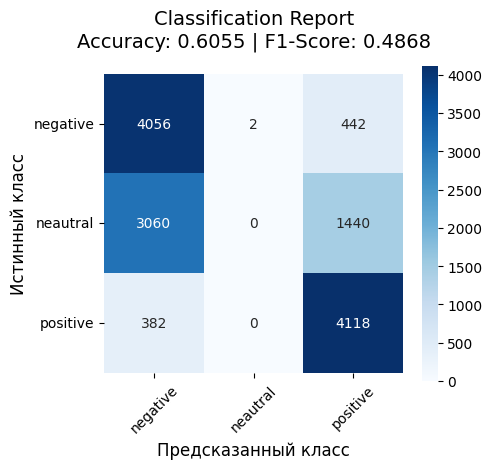

In [33]:
print_report_for_checkpoint(
    name="simple_rnn",
    checkpoint_name="best-l-4-es-300-hs-300-epoch=8-val_acc=0.605",
    rnn_class=nn.RNN,
    n_layers=4,
    embed_size=300,
    hidden_size=300,
    datamodule=dm,
    tokenizer=tokenizer,
)

Результаты получились ужасными, возможно проблема в датасете. Для positive и negative классов в целом результаты удовлетворительны, но полное игнорирование neautral (орфография оригинала сохранена) класса делает практическое применение модели бессмысленным. Есть вероятность того, что логика разметки в датасете отсутсвует. Полнота для negative и positive очень хорошая: 0.90 и 0.91, но точность слабая т. к часто происходит неправильное отнесение класса neautral к negative или positive классу.

/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.3
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got fork

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6157777905464172
         test_f1            0.4960925877094269
        test_loss           0.29477575421333313
     test_precision         0.41869741678237915
       test_recall          0.6157777309417725
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
📊 Classification Report
  Accuracy  : 0.6158
  Precision : 0.4187
  Recall    : 0.6158
  F1-Score  : 0.4961
🔍 Per-Class Statistics:
----------------------------------------
negative:
  Precision: 0.5406
  Recall   : 0.9247
  F1-Score : 0.6823
  Support  : 4500

neautral:
  Precision: 0.0000
  Recall   : 0.0000
  F1-Score : 0.0000
  Support  : 4500

posit

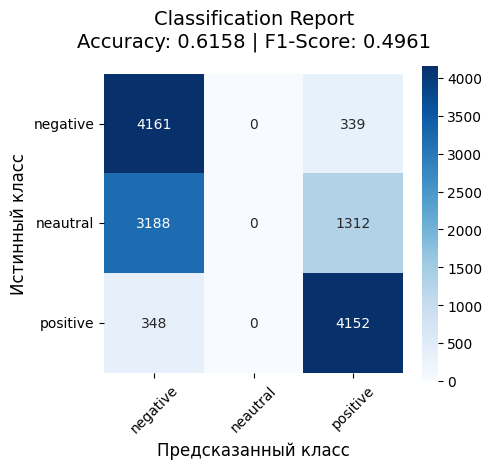

In [34]:
print_report_for_checkpoint(
    name="lstm",
    checkpoint_name="best-l-4-es-300-hs-300-epoch=6-val_acc=0.617",
    rnn_class=nn.LSTM,
    n_layers=4,
    embed_size=300,
    hidden_size=300,
    datamodule=dm,
    tokenizer=tokenizer,
)

Картина для классов negative и positive чуть лучше, модель стала реже путать эти классы, но neautral также полностью проигнорирован.

/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.5.5, which is newer than your current Lightning version: v2.5.3
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/pavel/Documents/uni_lessons_da_and_ml/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.618148148059845
         test_f1            0.5002758502960205
        test_loss           0.19152778387069702
     test_precision         0.42681050300598145
       test_recall           0.618148148059845
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
📊 Classification Report
  Accuracy  : 0.6181
  Precision : 0.4268
  Recall    : 0.6181
  F1-Score  : 0.5003
🔍 Per-Class Statistics:
----------------------------------------
negative:
  Precision: 0.5270
  Recall   : 0.9447
  F1-Score : 0.6766
  Support  : 4500

neautral:
  Precision: 0.0000
  Recall   : 0.0000
  F1-Score : 0.0000
  Support  : 4500

posit

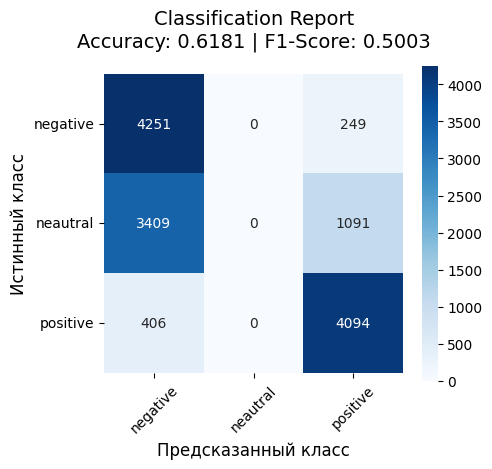

In [26]:
print_report_for_checkpoint(
    name="gru",
    checkpoint_name="best-l-4-es-300-hs-300-epoch=1-val_acc=0.616",
    rnn_class=nn.GRU,
    n_layers=4,
    embed_size=300,
    hidden_size=300,
    datamodule=dm,
    tokenizer=tokenizer,
)

Ситуация аналогична модели на базе LSTM